In [314]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torchdata.datapipes as dp
import torchtext.transforms as T
import spacy
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [340]:
tweets = pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')
texts = tweets['text']
labels = tweets['airline_sentiment']
tweets = pd.DataFrame(list(zip(texts, labels)), columns=['texts', 'labels'])
tweets

,texts,labels
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


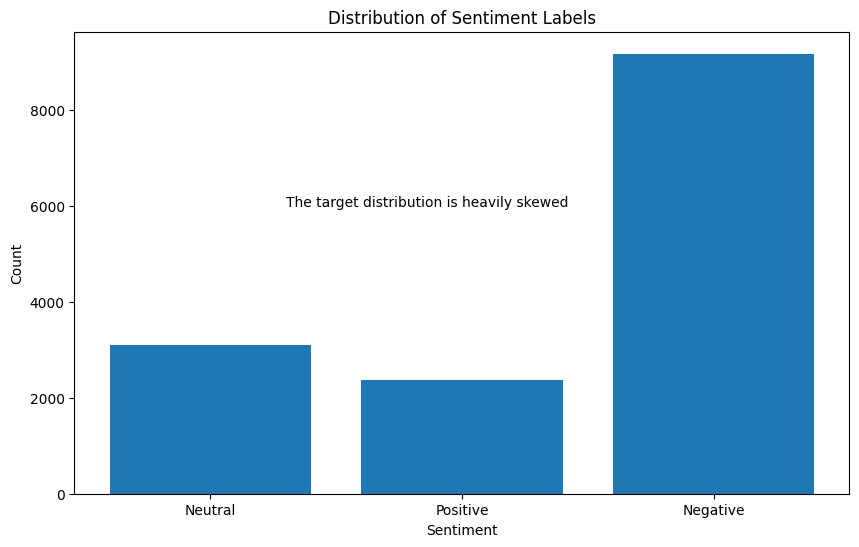

In [346]:
# Initialize counts
neutral_count = 0
positive_count = 0
negative_count = 0

# Count occurrences of each label
for label in tweets['labels']:
    if label == 'neutral':
        neutral_count += 1
    elif label == 'positive':
        positive_count += 1
    elif label == 'negative':
        negative_count += 1

# Plot the distribution
plt.figure(figsize=(10, 6))
labels = ['Neutral', 'Positive', 'Negative']
counts = [neutral_count, positive_count, negative_count]
plt.bar(labels, counts)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.annotate('The target distribution is heavily skewed', (0.3, 6000))
plt.show()

## Preprocess data
### - Remove special characters
### - Lower case every sentence
### - Remove stop words using nltk.porterstemmer
### - Tokenize each sentence to have lists of tokens

In [316]:
eng = spacy.load("en_core_web_sm") 

def engTokenize(text):
    """
    Tokenize an English text and return a list of tokens
    """
    return [token.text for token in eng.tokenizer(text)]

def preprocess(tweets):
    # Lowercase the text
    tweets['texts'] = tweets['texts'].apply(lambda x: x.lower())
    
    # Remove special characters
    tweets['texts'] = tweets['texts'].apply(lambda x: ''.join(char for char in x if char not in punctuation))
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tweets['texts'] = tweets['texts'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if word.lower() not in stop_words))
    
    # Tokenize the words
    tweets['tokenized_texts'] = tweets['texts'].apply(engTokenize)
    
    return tweets

# Label encode targets
label_encoder = LabelEncoder()
tweets['labels'] = label_encoder.fit_transform(tweets['labels'])

In [317]:
tweets = preprocess(tweets)
tweets

,texts,labels,tokenized_texts
0,virginamerica dhepburn said,1,"[virginamerica, dhepburn, said]"
1,virginamerica plus youve added commercials exp...,2,"[virginamerica, plus, you, ve, added, commerci..."
2,virginamerica didnt today must mean need take ...,1,"[virginamerica, did, nt, today, must, mean, ne..."
3,virginamerica really aggressive blast obnoxiou...,0,"[virginamerica, really, aggressive, blast, obn..."
4,virginamerica really big bad thing,0,"[virginamerica, really, big, bad, thing]"
...,...,...,...
14635,americanair thank got different flight chicago,2,"[americanair, thank, got, different, flight, c..."
14636,americanair leaving 20 minutes late flight war...,0,"[americanair, leaving, 20, minutes, late, flig..."
14637,americanair please bring american airlines bla...,1,"[americanair, please, bring, american, airline..."
14638,americanair money change flight dont answer ph...,0,"[americanair, money, change, flight, do, nt, a..."


## Prepare the data for our CNN
### This includes converting every sentence into a tensor where every word is a number corresponding to the index in our vocabolary

In [318]:
# Merge all tokenized sentences into a single list of strings
all_tokenized_sentences = [token for sublist in tweets['tokenized_texts'] for token in sublist]

# Get the unique words in a set
unique_words = set(str(token) for token in all_tokenized_sentences)

# Get a dictionary with the unique words and their corresponding indices
word_to_idx = {word: i for i, word in enumerate(unique_words)}

# Get the indexed sentences. This will be a tensor list of lists where every list has the indices of every word
indexed_sentences = [[word_to_idx[token] for token in tokens] for tokens in tweets['tokenized_texts']]

# Convert indexed sentences to tensors
sentence_tensors = [torch.tensor(indexed_sentence) for indexed_sentence in indexed_sentences]

# Account for the fact that not all sentences are equal in length
padded_sentences = pad_sequence([torch.tensor(indexed_sentence) for indexed_sentence in indexed_sentences], batch_first=True)

# Convert labels into test tensor
labels = torch.tensor(tweets['labels'])

# Get the count of words in our corpus
vocab_size = len(word_to_idx)

## Custom Data set

In [319]:
class TextDataset(Dataset):
    def __init__(self, padded_sentences, labels):
        self.padded_sentences = padded_sentences
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Retrieve the padded sentence and label for the given index
        padded_sentence = self.padded_sentences[idx]
        label = self.labels[idx]
        
        # Convert the padded sentence and label to PyTorch tensors
        padded_sentence_tensor = torch.tensor(padded_sentence)
        label_tensor = torch.tensor(label)
        
        return padded_sentence_tensor, label_tensor

## Split into train and test

In [320]:
# Split the data into training and testing sets
train_sentences, test_sentences, train_labels, test_labels = train_test_split(padded_sentences, labels, test_size=0.2, random_state=42)

# Create datasets and dataloaders for training and testing sets
train_dataset = TextDataset(train_sentences, train_labels)
test_dataset = TextDataset(test_sentences, test_labels)

batch_size = 32

# Create dataloaders for training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# CNN Model

In [321]:
class SentimentAnalysisCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv1d(embed_dim, embed_dim, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(embed_dim, embed_dim, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a dropout rate of 0.5
        self.bn = nn.BatchNorm1d(embed_dim)  # Add batch normalization layer
        self.fc = nn.Linear(embed_dim, 3)

    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        conved = torch.relu(self.conv1(embedded))
        conved = torch.relu(self.conv2(conved))
        conved = F.max_pool1d(conved, kernel_size=conved.size(2)).squeeze(2)  # Max pooling
        conved = self.dropout(conved)  # Apply dropout
        conved = self.bn(conved)  # Apply batch normalization
        return self.fc(conved)

In [322]:
model = SentimentAnalysisCNN(vocab_size, 100)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Set model to training mode
model.train()

# Define number of epochs
num_epochs = 25

Training Iteration:   0%|          | 0/366 [00:00<?, ?it/s]/tmp/ipykernel_33/692971658.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_sentence_tensor = torch.tensor(padded_sentence)
/tmp/ipykernel_33/692971658.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(label)


Epoch 1, Train Loss: 1.0673309670445696, Validation Loss: 0.9323618008139355


Epoch 2, Train Loss: 0.927917669379646, Validation Loss: 0.8321193723730702


Epoch 3, Train Loss: 0.8238308384118835, Validation Loss: 0.7674625655992435


Epoch 4, Train Loss: 0.7444572390102949, Validation Loss: 0.7049057372932226


Epoch 5, Train Loss: 0.683982021414517, Validation Loss: 0.681238596882325


Epoch 6, Train Loss: 0.6408158095319414, Validation Loss: 0.6653149346184861


Epoch 7, Train Loss: 0.6058629077803241, Validation Loss: 0.6513488624916702


Epoch 8, Train Loss: 0.5754146465186865, Validation Loss: 0.6400375444380964


Epoch 9, Train Loss: 0.547750673088871, Validation Loss: 0.6307178888816


Epoch 10, Train Loss: 0.526400663325044, Validation Loss: 0.6285441628570765


Epoch 11, Train Loss: 0.5048342744509379, Validation Loss: 0.6228224970603902


Epoch 12, Train Loss: 0.4855016498454933, Validation Loss: 0.6179818657578015


Epoch 13, Train Loss: 0.4679360526507018, Validation Loss: 0.6139232783369679


Epoch 14, Train Loss: 0.4545427185427296, Validation Loss: 0.6150097951211565


Epoch 15, Train Loss: 0.43287501936076117, Validation Loss: 0.612635620630504


Epoch 16, Train Loss: 0.42596961395010924, Validation Loss: 0.6157347989864037


Epoch 17, Train Loss: 0.41509778418990434, Validation Loss: 0.6124638889005275


Epoch 18, Train Loss: 0.395888582360549, Validation Loss: 0.6150124496449538


Epoch 19, Train Loss: 0.38305709470328086, Validation Loss: 0.614040437943297


Epoch 20, Train Loss: 0.37824151168266934, Validation Loss: 0.613420613150779


Epoch 21, Train Loss: 0.36295437540024356, Validation Loss: 0.6116920725895407


Epoch 22, Train Loss: 0.3558185030528105, Validation Loss: 0.6187175284317934


Epoch 23, Train Loss: 0.34402264626136897, Validation Loss: 0.6182772973196102


Epoch 24, Train Loss: 0.33401705882425514, Validation Loss: 0.6149515468891853


Epoch 25, Train Loss: 0.3307594106904144, Validation Loss: 0.6189365797355527


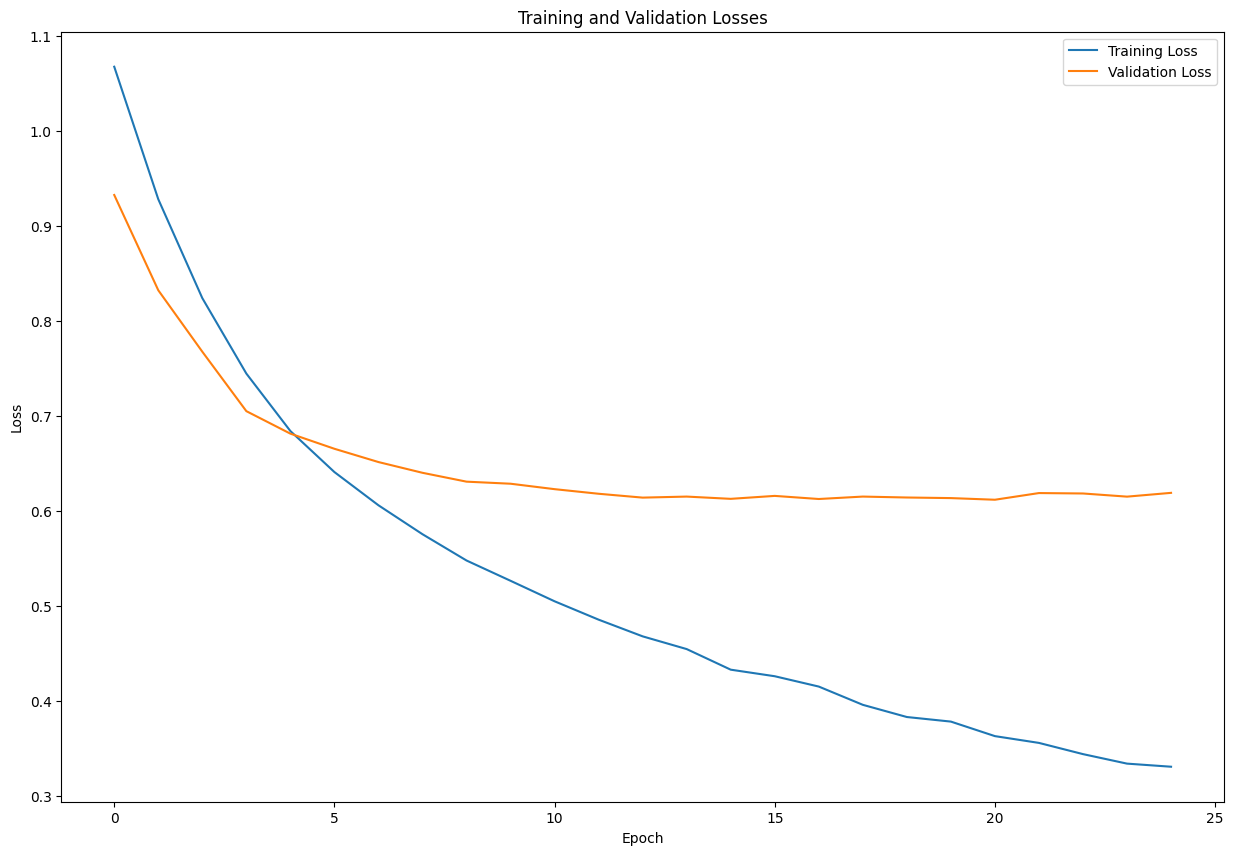

In [323]:
train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    train_loss = 0.0
    
    for inputs, labels in tqdm(train_dataloader, desc='Training Iteration', leave=False):
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels) 
        
        # Backward pass
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)  # Save training loss
    
    # Evaluation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader, desc='Validation Iteration', leave=False):
            # Forward pass
            outputs = model(inputs)
            
            # Compute loss
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
    
    # Calculate average validation loss for the epoch
    val_loss /= len(test_dataloader.dataset)
    val_losses.append(val_loss)  # Save validation loss
    # Print the training and validation losses for each epoch
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

# Create DataFrame for plotting
loss_df = pd.DataFrame({'Train Loss': train_losses, 'Validation Loss': val_losses})

# Plot the training and validation losses
plt.figure(figsize=(15, 10))
plt.plot(loss_df['Train Loss'], label='Training Loss')
plt.plot(loss_df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [328]:
# Define your sentence
sentence = "the flight was shit"

# Tokenize the sentence and convert it into a tensor
sentence_indices = torch.LongTensor([word_to_idx.get(word, 0) for word in sentence.split()])

# Set the model to evaluation mode
model.eval()

# Pass the tensor through the model
with torch.no_grad():
    outputs = model(sentence_indices.unsqueeze(0))  # Add extra dimension for batch size
    
# Get the predicted label
predicted_label_index = torch.argmax(outputs, dim=1).item()

# Map the predicted label index back to its original value
predicted_label = label_encoder.inverse_transform([predicted_label_index])

print("Predicted sentiment:", predicted_label)

Predicted sentiment: ['negative']
